**This notebook were used on Google Colab.**

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt


In [6]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz     # download data
!mkdir -p data                                                                                     # create data folder
!tar -xzvf speech_commands_v0.02.tar.gz -C data                                                    # unzip data to data/
!rm speech_commands_v0.02.tar.gz                                                                   # remove tar.gz file

A saída de streaming foi truncada nas últimas 5000 linhas.
./on/fc3ba625_nohash_0.wav
./on/db9d52d2_nohash_0.wav
./on/72242187_nohash_4.wav
./on/b0f5b16d_nohash_0.wav
./on/d9aa8c90_nohash_1.wav
./on/525eaa62_nohash_0.wav
./on/42e3f068_nohash_0.wav
./on/94d370bf_nohash_4.wav
./on/bf8d5617_nohash_0.wav
./on/e2b7d6d6_nohash_2.wav
./on/89ed36ab_nohash_0.wav
./on/30276d03_nohash_1.wav
./on/364c0853_nohash_0.wav
./on/7cbf645a_nohash_0.wav
./on/c98bbbd3_nohash_2.wav
./on/9a7c1f83_nohash_5.wav
./on/3589bc72_nohash_0.wav
./on/3ae5c04f_nohash_0.wav
./on/adc216c5_nohash_2.wav
./on/c50f55b8_nohash_15.wav
./on/324210dd_nohash_2.wav
./on/c120e80e_nohash_2.wav
./on/69086eb0_nohash_0.wav
./on/dce05676_nohash_1.wav
./on/435695e3_nohash_1.wav
./on/179a61b7_nohash_1.wav
./on/f5341341_nohash_0.wav
./on/91b03183_nohash_0.wav
./on/96d8bb6f_nohash_2.wav
./on/6a1908f8_nohash_0.wav
./on/6ace4fe1_nohash_1.wav
./on/84d1e469_nohash_1.wav
./on/ba676390_nohash_0.wav
./on/1dc86f91_nohash_4.wav
./on/3a929277_nohash_2

In [7]:
DATA_DIR = "data"

print("Files on data/ folder:", os.listdir(DATA_DIR))
print("Files on data/up/ folder:", os.listdir(f"{DATA_DIR}/up"))

Files on data/ folder: ['eight', 'zero', 'go', 'bed', 'house', 'two', 'forward', 'happy', 'one', '.DS_Store', 'seven', 'follow', 'on', 'three', 'left', 'no', 'bird', 'README.md', 'five', 'backward', 'learn', 'four', 'wow', 'stop', 'nine', 'LICENSE', '_background_noise_', 'six', 'tree', 'up', 'yes', 'down', 'marvin', 'dog', 'sheila', 'right', 'visual', 'validation_list.txt', 'cat', 'off', 'testing_list.txt']
Files on data/up/ folder: ['06f6c194_nohash_1.wav', '27c24504_nohash_0.wav', '15dd287d_nohash_0.wav', '325a0c39_nohash_1.wav', 'bfd26d6b_nohash_0.wav', 'd98dd124_nohash_1.wav', 'b6573c88_nohash_1.wav', '50a7d406_nohash_1.wav', 'c6a23ff5_nohash_0.wav', '26e573a9_nohash_1.wav', '626e323f_nohash_0.wav', '92a9c5e6_nohash_2.wav', 'aa753bb9_nohash_0.wav', 'cd7f8c1b_nohash_3.wav', '146d97db_nohash_0.wav', 'aa109cfb_nohash_0.wav', 'f4c77b26_nohash_0.wav', '3ec05c3d_nohash_0.wav', 'a16013b7_nohash_4.wav', '5a5721f8_nohash_1.wav', 'b26343e9_nohash_0.wav', '5b09db89_nohash_2.wav', '8b775397_no

In [8]:
categories: list[str] = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "bed", "bird", "cat", "dog", "happy", "house", "marvin", "sheila", "tree", "wow"]
mapping: dict[str, str] = {category:files for category, files in zip(categories, [os.listdir(f"{DATA_DIR}/{category}/") for category in categories])}
"""
mapping is a dict of this type:
{
    'yes': ['0a7c2a8d_nohash_0.wav', '0a7c2a8d_nohash_1.wav', ... , '0a7c2a8d_nohash_99.wav'],
    'no': ['0a7c2a8d_nohash_0.wav', '0a7c2a8d_nohash_1.wav',  ... , '0a7c2a8d_nohash_99.wav'],
    'up': ['0a7c2a8d_nohash_0.wav', '0a7c2a8d_nohash_1.wav',  ... , '0a7c2a8d_nohash_99.wav'],
    ...
    'wow': ['0a7c2a8d_nohash_0.wav', '0a7c2a8d_nohash_1.wav',  ... , '0a7c2a8d_nohash_99.wav'],
}
"""

rows: list[dict[str, str]] = [
    {
        "category": category,
        "path": f"{DATA_DIR}/{category}/{username}"
    }
    for category, usernames in mapping.items()
    for username in usernames
]

df = pd.DataFrame(rows)
df.head()

,category,path
0,yes,data/yes/06f6c194_nohash_1.wav
1,yes,data/yes/b4ea0d9a_nohash_7.wav
2,yes,data/yes/27c24504_nohash_0.wav
3,yes,data/yes/988e2f9a_nohash_0.wav
4,yes,data/yes/15dd287d_nohash_0.wav


In [9]:
total_files = len(df)
print("Total files:",total_files)

total_categories = df["category"].nunique()
print("Total categories:", total_categories)

duplicates = df["path"].duplicated().sum()
print("Duplicated files:", duplicates)

Total files: 97862
Total categories: 30
Duplicated files: 0


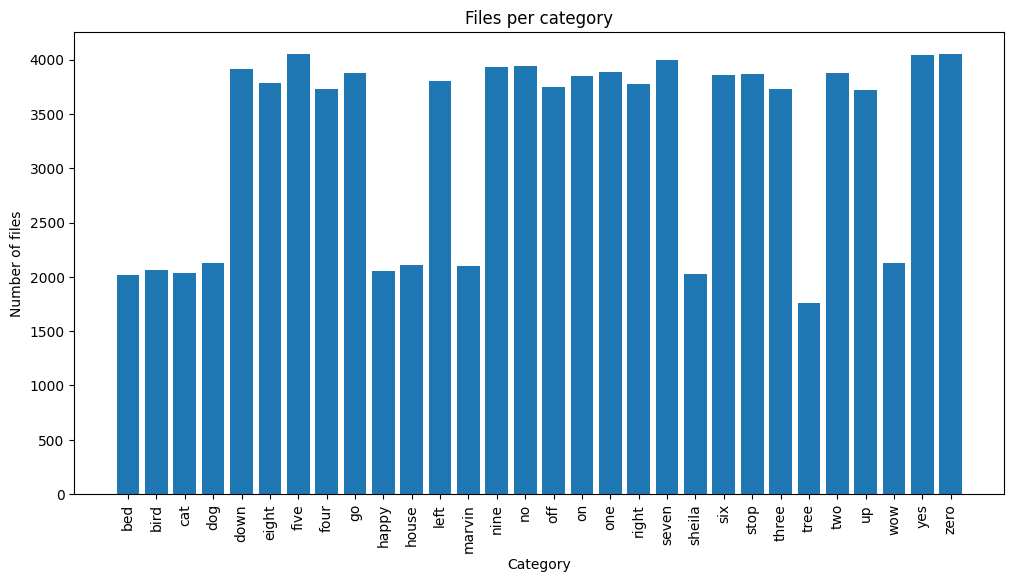

In [10]:
files_per_category = df["category"].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.bar(files_per_category.index, files_per_category.values)
plt.xlabel("Category")
plt.ylabel("Number of files")
plt.title("Files per category")
plt.xticks(rotation=90)
plt.show()

In [11]:
audio_path = df.loc[0, "path"]    # path for the first example
audio_binary = tf.io.read_file(audio_path)
audio, sample_rate = tf.audio.decode_wav(audio_binary)

print(audio.shape)
print(sample_rate)

(16000, 1)
tf.Tensor(16000, shape=(), dtype=int32)


In [12]:
print(tf.squeeze(audio, axis=-1).shape)

(16000,)


In [13]:
print(type(audio))
print(audio[0])

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([-6.1035156e-05], shape=(1,), dtype=float32)


Now, we are going to create two columns:


*   One for audio values (tf.Tensor)
*   The other for the sample rate to check if every file has the same



In [14]:
from IPython.display import Audio, display
# get the first observation of "down" category
audio_path = df[df["category"]=="down"].reset_index().loc[0, 'path']
display(Audio(filename=audio_path))

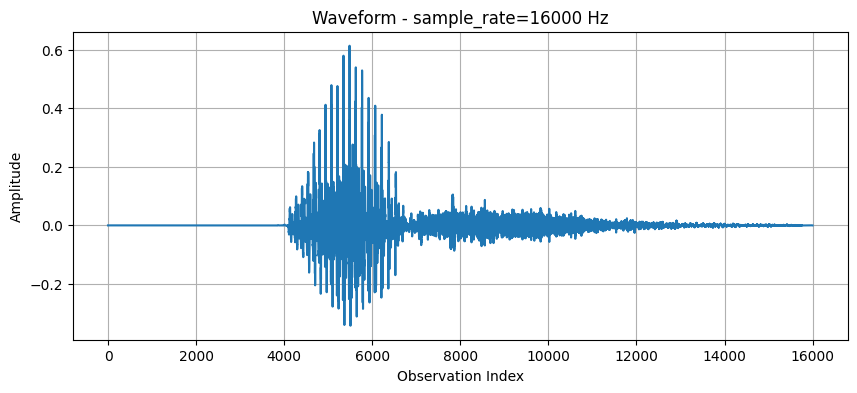

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(audio)
plt.title(f"Waveform - sample_rate={sample_rate} Hz")
plt.xlabel("Observation Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.savefig("time_vs_frequency_down.svg")
plt.show()


In [16]:
# I'm going to work with the following categories
target_cat: list[str] = ["up", "down", "left", "right", "on", "off", "stop", "go"]
df = df[df["category"].isin(target_cat)].copy().reset_index(drop=True)

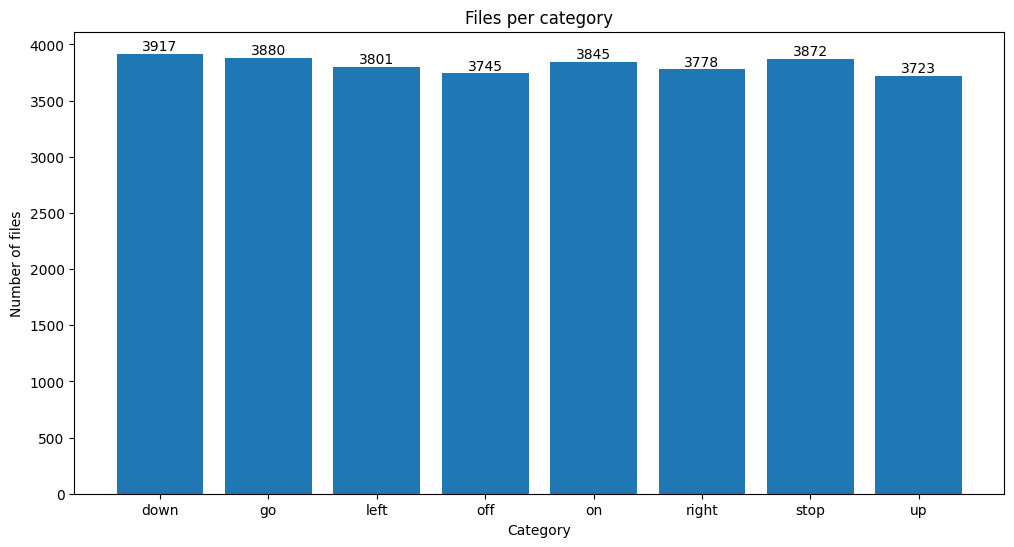

In [17]:
files_per_category = df["category"].value_counts().sort_index()
plt.figure(figsize=(12, 6))
bars = plt.bar(files_per_category.index, files_per_category.values)
plt.xlabel("Category")
plt.ylabel("Number of files")
plt.title("Files per category")
plt.xticks()
# Add values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position (center of bar)
        height,                             # y position (top of bar)
        f"{int(height)}",                   # text (convert to int if counts)
        ha="center", va="bottom"            # horizontal/vertical alignment
    )
plt.savefig("class_dist.svg")
plt.show()

In [18]:
from scipy.stats import chisquare

counts = df["category"].value_counts().sort_index()
observed = counts.values

expected = np.full_like(observed, observed.mean(), dtype=float)

chi2, p = chisquare(f_obs=observed, f_exp=expected)
print("chi2 =", chi2, "p-value =", p)

chi2 = 8.768528516737017 p-value = 0.26970477970050055


**Hypotheses (for the chi-square goodness-of-fit test)**



* Null hypothesis (H0): All classes have the same probability; in other words, the class distribution is uniform (the dataset is balanced across categories).

* Alternative hypothesis (H1): At least one class has a different probability; the class distribution is not uniform (there is some class imbalance).

Since p-value is around 0.27, which is greater than common significance levels such as 0.05 or 0.01:

* You do not reject the null hypothesis H0.
* Statistically, there is no evidence that the class proportions differ from a uniform distribution.
* In practical terms, the dataset is consistent with being balanced across the categories, and the small differences in counts between classes are not statistically significant.




In [19]:
SAMPLE_RATE = 16000
FRAME_LENGTH = 320      # 40 ms  (0.04 * 16000)
FRAME_STEP   = 160      # 20 ms  (0.02 * 16000)
FFT_LENGTH   = 1024
NUM_MEL_BINS = 40
LOW_FREQ     = 20.0
HIGH_FREQ    = 4000.0   # up to 4 kHz is usually enough for speech
NUM_MFCCS    = 13

In [20]:
audio_binary = tf.io.read_file(audio_path)
audio, sample_rate = tf.audio.decode_wav(audio_binary)

stft = tf.signal.stft(
      signals=tf.squeeze(audio, axis=-1),
      frame_length=FRAME_LENGTH,
      frame_step=FRAME_STEP,
      fft_length=FFT_LENGTH
  )
spectrogram = tf.abs(stft)  # magnitude

In [21]:
num_spectrogram_bins = spectrogram.shape[-1]

linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins=NUM_MEL_BINS,
      num_spectrogram_bins=num_spectrogram_bins,
      sample_rate=SAMPLE_RATE,
      lower_edge_hertz=LOW_FREQ,
      upper_edge_hertz=HIGH_FREQ
  )

mel_spectrogram = tf.tensordot(
      spectrogram, linear_to_mel_weight_matrix, axes=1
  )
  # Keep the shape info right for TF
mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(
      [NUM_MEL_BINS]
  ))

In [22]:
# avoid log(0)
log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
# take only the first NUM_MFCCS coefficients
mfccs = mfccs[..., :NUM_MFCCS]  # shape: [frames, NUM_MFCCS]

In [23]:
mfccs.shape

TensorShape([99, 13])

In [24]:
mfccs_np = mfccs.numpy().T   # transpose to [NUM_MFCCS, frames] for plotting
print(mfccs_np.shape)        # e.g. (13, 49)

(13, 99)


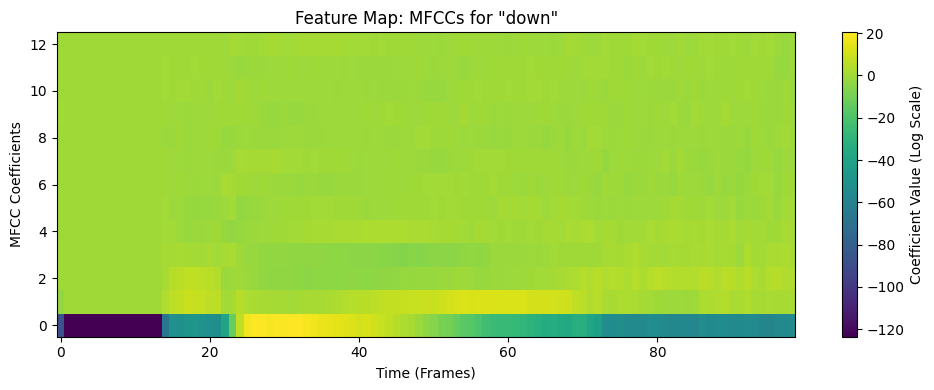

In [25]:
plt.figure(figsize=(10, 4))
plt.imshow(mfccs_np, aspect='auto', origin='lower', cmap='viridis')
plt.xlabel('Time (Frames)')
plt.ylabel('MFCC Coefficients')
plt.colorbar(label='Coefficient Value (Log Scale)')
plt.title('Feature Map: MFCCs for "down"')
plt.tight_layout()
plt.savefig("MFCCs.svg")
plt.show()

In [26]:
categories: list[str] = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "bed", "bird", "cat", "dog", "happy", "house", "marvin", "sheila", "tree", "wow"]
mapping: dict[str, str] = {category:files for category, files in zip(categories, [os.listdir(f"data/{category}/") for category in categories])}
"""
mapping is a dict of this type:
{
    'yes': ['0a7c2a8d_nohash_0.wav', '0a7c2a8d_nohash_1.wav', ... , '0a7c2a8d_nohash_99.wav'],
    'no': ['0a7c2a8d_nohash_0.wav', '0a7c2a8d_nohash_1.wav',  ... , '0a7c2a8d_nohash_99.wav'],
    'up': ['0a7c2a8d_nohash_0.wav', '0a7c2a8d_nohash_1.wav',  ... , '0a7c2a8d_nohash_99.wav'],
    ...
    'wow': ['0a7c2a8d_nohash_0.wav', '0a7c2a8d_nohash_1.wav',  ... , '0a7c2a8d_nohash_99.wav'],
}
"""

rows: list[dict[str, str]] = [
    {
        "category": category,
        "path": f"data/{category}/{username}"
    }
    for category, usernames in mapping.items()
    for username in usernames
]

df = pd.DataFrame(rows)
df.head()

,category,path
0,yes,data/yes/06f6c194_nohash_1.wav
1,yes,data/yes/b4ea0d9a_nohash_7.wav
2,yes,data/yes/27c24504_nohash_0.wav
3,yes,data/yes/988e2f9a_nohash_0.wav
4,yes,data/yes/15dd287d_nohash_0.wav


In [27]:
# Your target categories, in a fixed order
target_cat = ["up", "down", "left", "right", "on", "off", "stop", "go"]
class_to_id = {c: i for i, c in enumerate(target_cat)}

# Filter df to those categories if not already
df = df[df["category"].isin(target_cat)].copy().reset_index(drop=True)

paths = df["path"].astype(str).values
labels = df["category"].map(class_to_id).astype(np.int32).values

In [28]:
from sklearn.model_selection import train_test_split

paths = np.array(paths)
labels = np.array(labels)

# 1) Train vs (val+test): 80% / 20%, stratified
paths_train, paths_temp, labels_train, labels_temp = train_test_split(
    paths,
    labels,
    test_size=0.2,          # 20% -> will become 10% val + 10% test
    stratify=labels,
    random_state=42,
)

# 2) (val+test) -> val and test: 50% / 50%, stratified
paths_val, paths_test, labels_val, labels_test = train_test_split(
    paths_temp,
    labels_temp,
    test_size=0.5,          # 0.5 * 20% = 10% of total
    stratify=labels_temp,
    random_state=42,
)

In [29]:
SAMPLE_RATE = 16000
FRAME_LENGTH = 640      # 40 ms
FRAME_STEP   = 320      # 20 ms
FFT_LENGTH   = 1024
NUM_MEL_BINS = 40
LOW_FREQ     = 20.0
HIGH_FREQ    = 4000.0
NUM_MFCCS    = 13

In [30]:
# Load WAV → fixed‑length waveform
def load_wav_16k_mono(path):
    audio_binary = tf.io.read_file(path)
    audio, sr = tf.audio.decode_wav(audio_binary)  # [samples, channels]
    audio = tf.squeeze(audio, axis=-1)             # [samples]

    # Crop or pad to exactly 1 s (16000 samples)
    audio = audio[:SAMPLE_RATE]
    padding = SAMPLE_RATE - tf.shape(audio)[0]
    audio = tf.pad(audio, paddings=[[0, tf.maximum(0, padding)]])

    return audio  # [16000]

# Waveform → MFCC (all in TF, no pandas)
def waveform_to_mfcc(waveform):
    # STFT
    stft = tf.signal.stft(
        waveform,
        frame_length=FRAME_LENGTH,
        frame_step=FRAME_STEP,
        fft_length=FFT_LENGTH,
    )
    spectrogram = tf.abs(stft)  # [frames, fft_bins]

    num_spectrogram_bins = spectrogram.shape[-1]
    mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=NUM_MEL_BINS,
        num_spectrogram_bins=num_spectrogram_bins,
        sample_rate=SAMPLE_RATE,
        lower_edge_hertz=LOW_FREQ,
        upper_edge_hertz=HIGH_FREQ,
    )

    mel_spectrogram = tf.tensordot(spectrogram, mel_matrix, axes=1)
    mel_spectrogram.set_shape(
        spectrogram.shape[:-1].concatenate([NUM_MEL_BINS])
    )

    log_mel = tf.math.log(mel_spectrogram + 1e-6)

    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel)[..., :NUM_MFCCS]
    # shape: [num_frames, NUM_MFCCS]
    return mfccs

# Combine: path, label → (MFCC, label)
def preprocess_example(path, label):
    waveform = load_wav_16k_mono(path)
    mfcc = waveform_to_mfcc(waveform)      # [T, C]
    mfcc = tf.expand_dims(mfcc, -1)        # [T, C, 1] -> like a small image
    return mfcc, label


In [31]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(paths, labels, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), reshuffle_each_iteration=True)
    ds = ds.map(preprocess_example, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(paths_train, labels_train, shuffle=True)
val_ds   = make_dataset(paths_val,   labels_val,   shuffle=False)
test_ds  = make_dataset(paths_test,  labels_test,  shuffle=False)

In [32]:
# sanity check
mfcc_batch, label_batch = next(iter(train_ds))
print(mfcc_batch.shape, label_batch.shape)
# e.g. (64, 49, 13, 1) (64,)

(64, 49, 13, 1) (64,)


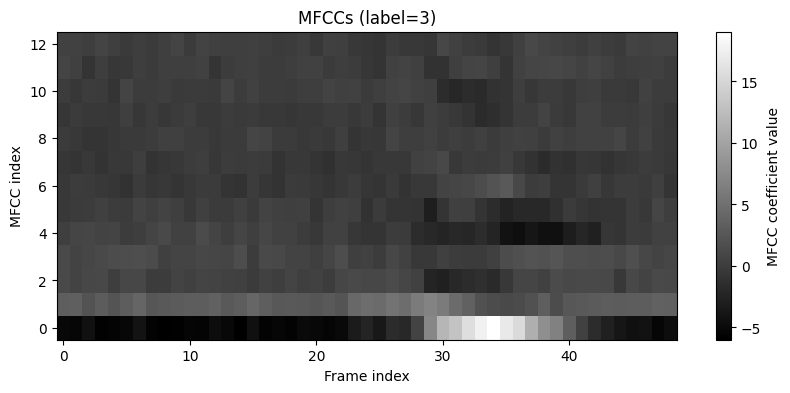

In [33]:
# plot for a single example

mfcc_example = tf.squeeze(mfcc_batch[0], axis=-1).numpy().T  # [NUM_MFCCS, T]

plt.figure(figsize=(10, 4))
plt.imshow(mfcc_example, aspect="auto", origin="lower", cmap="gray")
plt.colorbar(label="MFCC coefficient value")
plt.xlabel("Frame index")
plt.ylabel("MFCC index")
plt.title(f"MFCCs (label={label_batch[0].numpy()})")
plt.show()

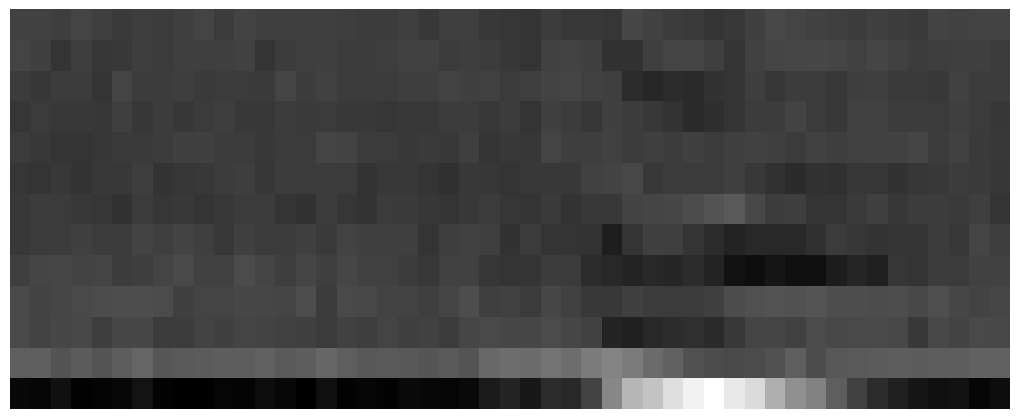

In [34]:
plt.figure(figsize=(10, 4))
plt.imshow(mfcc_example, aspect="auto", origin="lower", cmap="gray")
plt.axis("off")                         # Remove eixos
plt.gca().set_frame_on(False)           # Remove borda/frame
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove margens
plt.show()

In [35]:
# Get one batch to infer input shape
for xb, yb in train_ds.take(1):
    _, T, NUM_MFCCS, C = xb.shape  # C should be 1
    input_shape = (int(T), int(NUM_MFCCS), int(C))
    print(input_shape)
    break

num_classes = len(np.unique(labels_train))
print(num_classes)

(49, 13, 1)
8


In [36]:
from tf_keras import Sequential
from tf_keras.layers import Conv2D, ReLU, Flatten, Dense, Lambda, Reshape
from tf_keras.initializers import TruncatedNormal
import tf_keras

input_shape = (49, 13, 1)
num_classes = 8  # change if needed

def debug_shape(x):
    tf.print("before Flatten shape:", tf.shape(x))
    return x

model = Sequential([
    Conv2D(
        filters=8,
        kernel_size=(10, 8),
        strides=(2, 2),
        padding="same",
        kernel_initializer=TruncatedNormal(stddev=0.01),
        bias_initializer="zeros",
        input_shape=input_shape,
        name="first_conv",
    ),
    ReLU(name="first_relu"),
    Flatten(name="flatten"),
    Dense(
        num_classes,
        activation=None,
        kernel_initializer=TruncatedNormal(stddev=0.01),
        bias_initializer="zeros",
        name="final_fc",
    ),
])

model.compile(
    optimizer=tf_keras.optimizers.Adam(),
    loss=tf_keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_conv (Conv2D)         (None, 25, 7, 8)          648       
                                                                 
 first_relu (ReLU)           (None, 25, 7, 8)          0         
                                                                 
 flatten (Flatten)           (None, 1400)              0         
                                                                 
 final_fc (Dense)            (None, 8)                 11208     
                                                                 
Total params: 11856 (46.31 KB)
Trainable params: 11856 (46.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
%%time

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
)

Epoch 1/15
382/382 [==============================] - 52s 135ms/step - loss: 1.1122 - accuracy: 0.6211 - val_loss: 0.8550 - val_accuracy: 0.7111
Epoch 2/15
382/382 [==============================] - 33s 87ms/step - loss: 0.6724 - accuracy: 0.7796 - val_loss: 0.6596 - val_accuracy: 0.7742
Epoch 3/15
382/382 [==============================] - 33s 87ms/step - loss: 0.5519 - accuracy: 0.8223 - val_loss: 0.5824 - val_accuracy: 0.8004
Epoch 4/15
382/382 [==============================] - 33s 87ms/step - loss: 0.4902 - accuracy: 0.8413 - val_loss: 0.5935 - val_accuracy: 0.7971
Epoch 5/15
382/382 [==============================] - 33s 85ms/step - loss: 0.4430 - accuracy: 0.8564 - val_loss: 0.5682 - val_accuracy: 0.8151
Epoch 6/15
382/382 [==============================] - 34s 90ms/step - loss: 0.4097 - accuracy: 0.8667 - val_loss: 0.5316 - val_accuracy: 0.8190
Epoch 7/15
382/382 [==============================] - 35s 91ms/step - loss: 0.3882 - accuracy: 0.8720 - val_loss: 0.5356 - val_accuracy

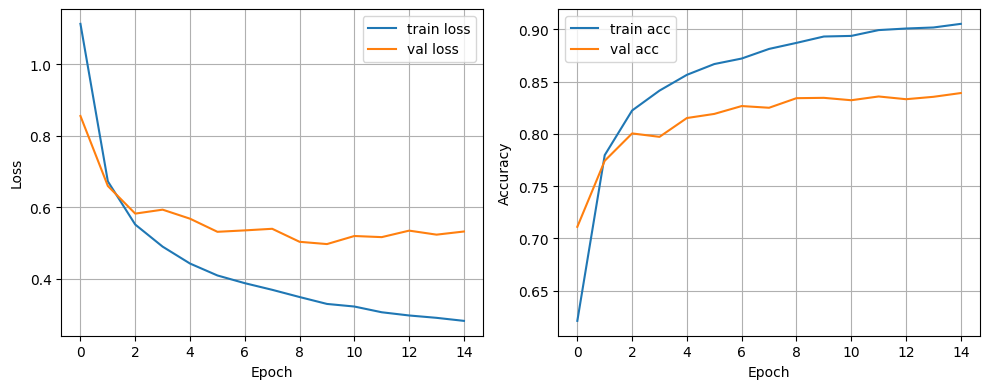

In [39]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = history.history

    plt.figure(figsize=(10, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(hist["loss"], label="train loss")
    if "val_loss" in hist:
        plt.plot(hist["val_loss"], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(hist["accuracy"], label="train acc")
    if "val_accuracy" in hist:
        plt.plot(hist["val_accuracy"], label="val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history)

In [40]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)

48/48 [==============================] - 5s 97ms/step - loss: 0.5144 - accuracy: 0.8433
Test accuracy: 0.8433104157447815


In [41]:
paths_test

array(['data/up/e55a2b20_nohash_0.wav', 'data/off/2fee065a_nohash_1.wav',
       'data/go/2356b88d_nohash_0.wav', ...,
       'data/right/cb62dbf1_nohash_0.wav',
       'data/right/70a00e98_nohash_2.wav',
       'data/stop/78622c2b_nohash_0.wav'], dtype=object)

In [44]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Obtenha previsões do modelo
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds_classes)

2/2 [==============================] - 0s 16ms/step


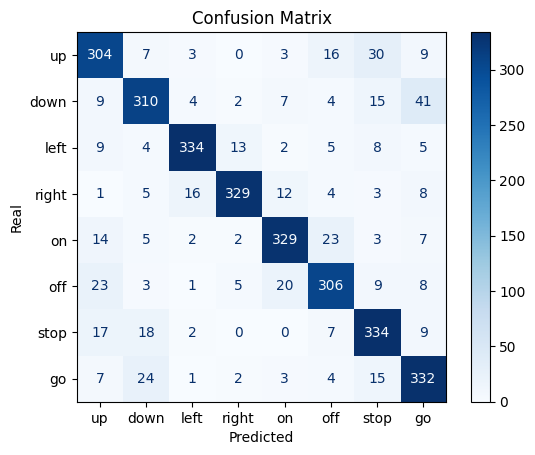

In [45]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_cat)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title("Confusion Matrix")
plt.show()

In [46]:
from IPython.display import Audio, display

wrongs = [i for i, (path, pred) in enumerate(zip(paths_test, y_pred)) if path.split('/')[1] != target_cat[pred]]
for idx in errados[:5]:
    path = paths_test[idx]
    real_label = caminho.split('/')[1]
    predicted = target_cat[y_pred[idx]]
    print(f"File path: {caminho}")
    print(f"Real: {real_label} --- Predicted: {previsto}")
    display(Audio(filename=caminho))

File path: data/left/88b7c5fa_nohash_0.wav
Real: left --- Predicted: stop


File path: data/left/88b7c5fa_nohash_0.wav
Real: left --- Predicted: stop


File path: data/left/88b7c5fa_nohash_0.wav
Real: left --- Predicted: stop


File path: data/left/88b7c5fa_nohash_0.wav
Real: left --- Predicted: stop


File path: data/left/88b7c5fa_nohash_0.wav
Real: left --- Predicted: stop
